In [56]:
from stackapi import StackAPI
import requests
from langdetect import detect
import time
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
from nltk.corpus import stopwords
import nltk
from wordcloud import WordCloud

In [38]:
def df_save(min_score=15, min_tags=2, max_tags=6, min_title_length=10, max_title_length=100, save_path="data.csv"):
# Initialization
    SITE = StackAPI('stackoverflow')
    SITE.max_pages = 25  # Default limit
    SITE.page_size = 100  # Max page size
    
    try:
        df_existing = pd.read_csv(save_path)
        all_data = df_existing.to_dict('records')
        print(f"Reprise de la collecte. {len(df_existing)} lignes déjà récupérées.")
        current_min_score = df_existing['score'].min()  # Commencer avec le score minimum déjà récupéré
    except FileNotFoundError:
        all_data = []
    
    # Define start and end dates
    start_date = datetime.datetime(2020, 1, 1)
    end_date = datetime.datetime(2023, 10, 1)
    
    # Time interval for each segment (e.g., 15 days)
    delta = datetime.timedelta(days=60)
    
    current_start = start_date
    
    while current_start < end_date:
        print("start")
        current_end = min(current_start + delta, end_date)
    
        # Convert dates to Unix timestamps
        fromdate = int(current_start.timestamp())
        todate = int(current_end.timestamp())
    
        try:
            # Fetch questions
            questions = SITE.fetch('questions',
                                   fromdate=fromdate,
                                   todate=todate,
                                   min=min_score,
                                   sort='votes',
                                   )
        except Exception as e:
            print(f"Error fetching questions from {current_start} to {current_end}: {e}")
            time.sleep(5)  # Wait 5 seconds before retrying
            continue
        
        # Process questions and collect data
        df = []
        print("questions")
        for question in questions['items']:
            # Check additional criteria
            if (min_tags <= len(question.get('tags', [])) <= max_tags and
                min_title_length <= len(question.get('title', '')) <= max_title_length):
                data.append({
                    'title': question['title'],
                    'score': question['score'],
                    'tags': ','.join(question['tags']),
                    'creation_date': datetime.datetime.fromtimestamp(question['creation_date']).isoformat(),
                })
        all_data.extend(data)
        print("extend")
        df_filtered = pd.DataFrame(all_data)
        df_filtered.to_csv(save_path, index=False)
        print(f"{len(data)} lignes récupérées de {current_start} à {current_end}.")
        print(f"{len(all_data)} lignes sauvegardées dans {save_path}.")       
    
        current_start = current_end
        time.sleep(0.2)  # Small pause to avoid overloading the API


Possible Filter to get consistant data for tag prediction :
- By the score
- by the number of tags
- Temporality
- title(question) size
- by the popularity(view)
- language
- 

In [24]:
df = df_save()

Reprise de la collecte. 16875 lignes déjà récupérées.
start
Error fetching questions from 2020-01-01 00:00:00 to 2020-03-01 00:00:00: ('https://api.stackexchange.com/2.3/questions/?pagesize=100&page=1&filter=default&fromdate=1577833200&todate=1583017200&min=15&sort=votes&site=stackoverflow', 502, 'throttle_violation', 'Violation of backoff parameter')


KeyboardInterrupt: 

In [67]:
df = pd.read_csv("data.csv")

In [68]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17193 entries, 0 to 17192
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   title          17193 non-null  object
 1   score          17193 non-null  int64 
 2   tags           17193 non-null  object
 3   creation_date  17193 non-null  object
dtypes: int64(1), object(3)
memory usage: 537.4+ KB


In [69]:
df.describe()

,score
count,17193.000000
mean,32.564299
std,40.968594
min,15.000000
25%,17.000000
50%,22.000000
75%,33.000000
max,2430.000000


In [72]:
df.drop_duplicates('title', inplace=True)
df.duplicated('title').sum()

np.int64(0)

In [73]:
def plot_tags(df):
    if 'tags_split' not in df.columns:
        df['tags_split'] = df['tags'].str.split(',')
    all_tags = [tag for sublist in df['tags_split'] for tag in sublist]

    tag_counts = pd.Series(all_tags).value_counts()
    plt.figure(figsize=(12, 6))
    tag_counts.head(30).plot(kind='bar')
    plt.title('Top 30 Most Frequent Tags')
    plt.ylabel('Frequency')
    plt.xlabel('Tags')
    plt.xticks(rotation=70)
    plt.tight_layout()
    plt.show()


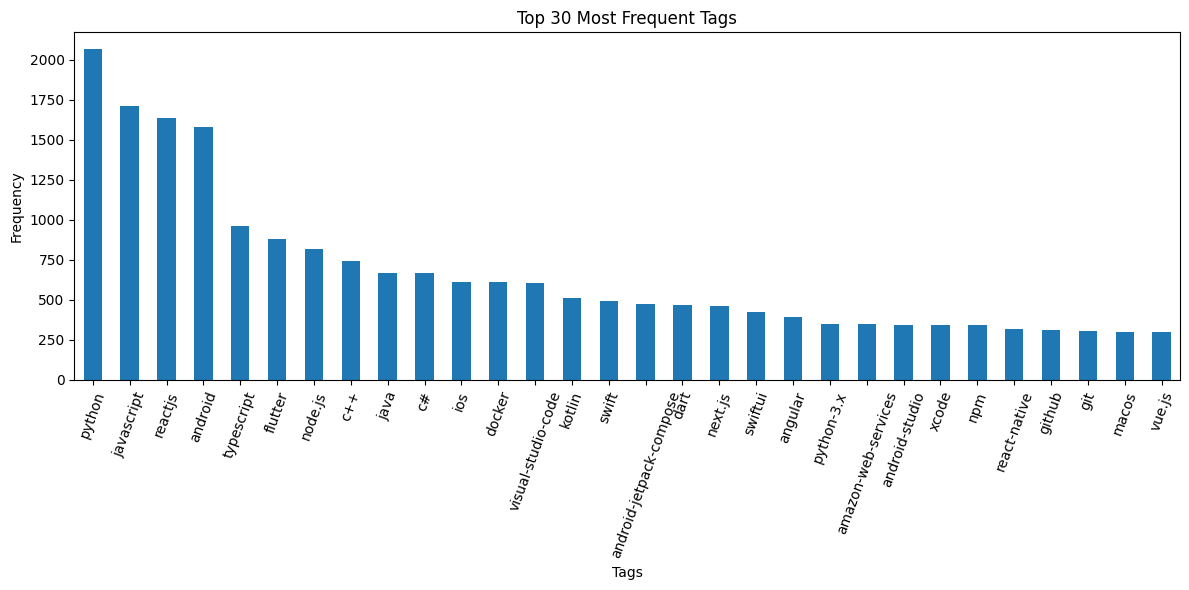

In [74]:
plot_tags(df)

In [75]:
def boxplot_scores(df):
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=df, x='score')
    plt.title('Boxplot of Question Scores')
    plt.xlabel('Score')
    plt.show()   

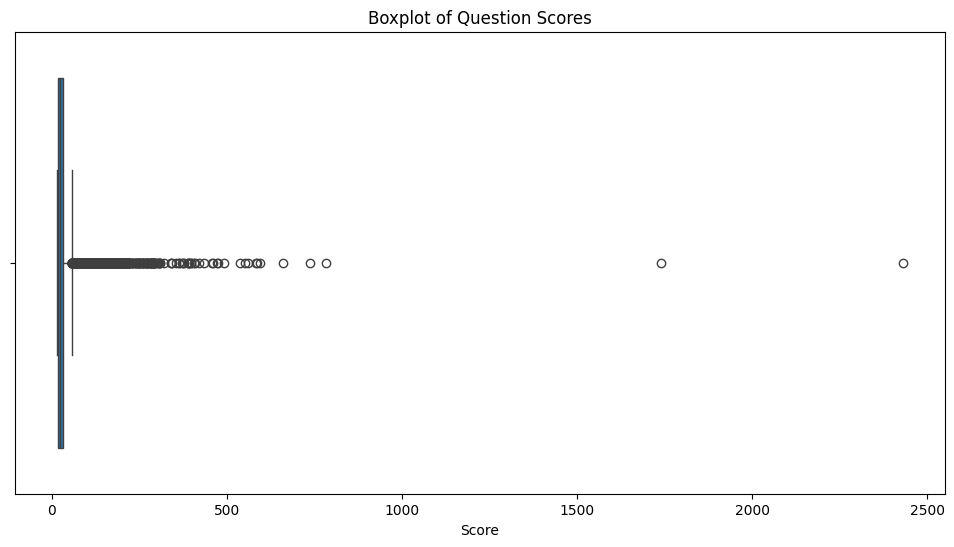

In [76]:
boxplot_scores(df)

In [116]:
def is_english(text):
    try:
        return detect(text) == 'en'
    except:
        return False

def clean_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove special characters and numbers
    text = re.sub(r'[^a-z\s]', '', text)
    # Tokenize the text
    words = text.split()
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    return ' '.join(words)
def clean_common(text, frequent_words):
    words = text.split()
    words = [word for word in words if word not in frequent_words]
    return ' '.join(words)
    

def clean_df(df):
    # df['is_english'] = df['title'].apply(is_english)
    data_en = df[ df['is_english'] == True ].copy()
    nltk.download('stopwords')
    data_en['cleaned_title'] = data_en['title'].apply(clean_text)
    all_words = [word for title in df['title'].str.split() for word in title]
    frequent_words = [word for word, count in Counter(all_words).most_common(21)]
    print(frequent_words)
    data_en['cleaned_title'] = data_en['cleaned_title'].apply(lambda x: clean_common(x, frequent_words))
    return data_en

def plot_WordCloud(df):
    all_words = [word for title in df['cleaned_title'].str.split() for word in title]
    c = Counter(all_words)
    word_counts = {word: count for word, count in c.items()}
    # Generate a word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_counts)
    
    # Plot the word cloud
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')  # Remove axes
    plt.title('Word Cloud of Most Frequent Words in Titles', fontsize=16)
    plt.show()   
    

def plot_words(df):
    all_words = [word for title in df['cleaned_title'].str.split() for word in title]
    words, counts = zip(*Counter(all_words).most_common(20))
    plt.figure(figsize=(10, 6))
    plt.bar(words, counts, color='skyblue')
    plt.title('Top 20 Most Frequent Words in Titles', fontsize=16)
    plt.ylabel('Frequency', fontsize=12)
    plt.xlabel('Words', fontsize=12)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.tight_layout()
    plt.show()

In [94]:
df.head()

,title,score,tags,creation_date,tags_split,is_english
0,Is there a compatibility list for Angular / An...,410,"node.js,angular,angular-cli",2020-02-16T13:28:52,"[node.js, angular, angular-cli]",True
1,How can I use optional chaining with arrays an...,320,"javascript,arrays,typescript,function,optional...",2020-01-07T08:05:02,"[javascript, arrays, typescript, function, opt...",True
2,What is the use of PYTHONUNBUFFERED in docker ...,308,"django,docker,dockerfile",2020-01-19T17:23:11,"[django, docker, dockerfile]",True
3,error /node_modules/node-sass: Command failed,308,"node.js,vue.js,yarnpkg",2020-02-25T13:07:28,"[node.js, vue.js, yarnpkg]",False
4,What does model.eval() do in pytorch?,287,"python,machine-learning,deep-learning,pytorch",2020-02-01T16:58:15,"[python, machine-learning, deep-learning, pyto...",True


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\milan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['to', 'in', 'How', 'a', 'the', 'not', 'is', 'with', 'of', 'and', 'for', 'on', 'I', '-', 'from', 'using', 'use', 'when', 'an', 'What', 'error']


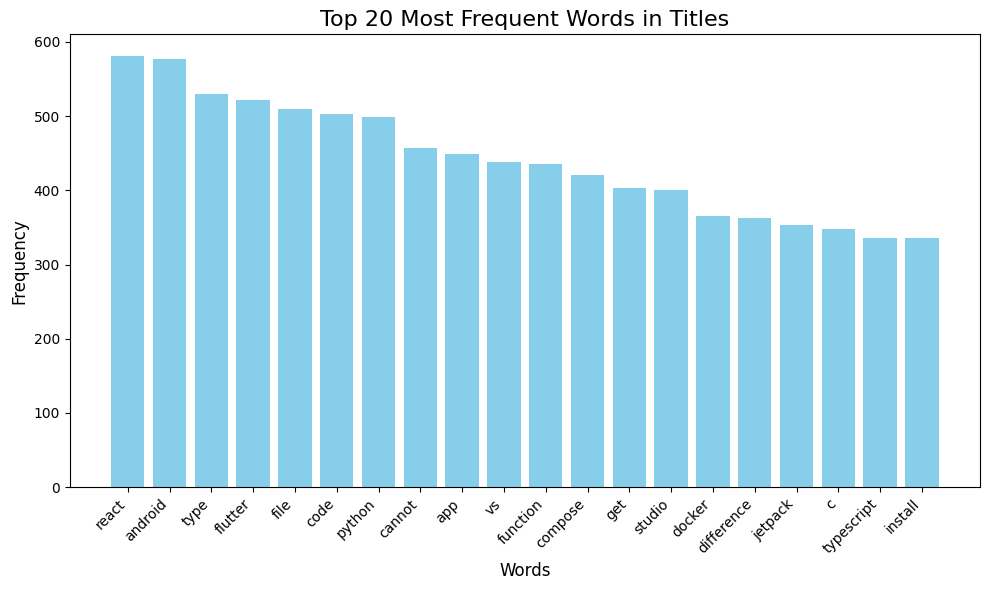

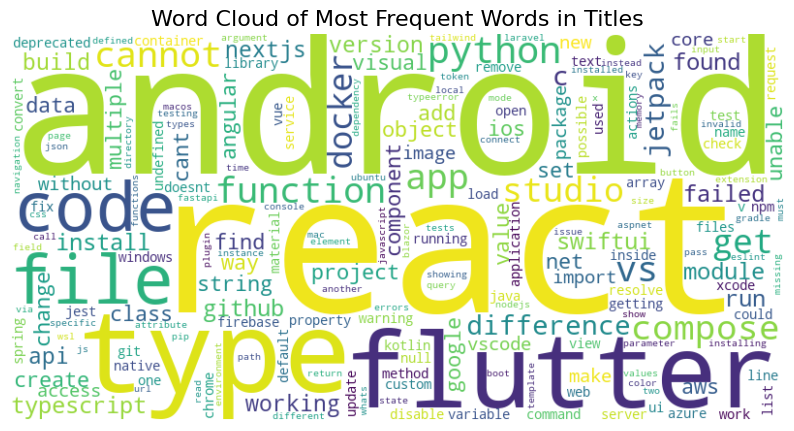

In [117]:
X_clean = clean_df(df)
plot_words(X_clean)
plot_WordCloud(X_clean)

In [118]:

X_clean.head()

,title,score,tags,creation_date,tags_split,is_english,cleaned_title
0,Is there a compatibility list for Angular / An...,410,"node.js,angular,angular-cli",2020-02-16T13:28:52,"[node.js, angular, angular-cli]",True,compatibility list angular angularcli nodejs
1,How can I use optional chaining with arrays an...,320,"javascript,arrays,typescript,function,optional...",2020-01-07T08:05:02,"[javascript, arrays, typescript, function, opt...",True,optional chaining arrays functions
2,What is the use of PYTHONUNBUFFERED in docker ...,308,"django,docker,dockerfile",2020-01-19T17:23:11,"[django, docker, dockerfile]",True,pythonunbuffered docker file
4,What does model.eval() do in pytorch?,287,"python,machine-learning,deep-learning,pytorch",2020-02-01T16:58:15,"[python, machine-learning, deep-learning, pyto...",True,modeleval pytorch
5,How to Set port in next.js,284,"javascript,reactjs,npm,port,next.js",2020-02-10T10:33:48,"[javascript, reactjs, npm, port, next.js]",True,set port nextjs
